## Computer Vision

1. Face Recognition:
Use CV to recognize faces for user's logins validation.

2. Image Similarity Search:
Use CV to search images with other image as query and find similar images.

## Face Recognition

In [1]:
from facenet_pytorch import InceptionResnetV1
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mtcnn import MTCNN
from utils.computer_vision import FaceDataset, plot_images_horizontal
from torch.utils.data import DataLoader
from qdrant_client import QdrantClient
from qdrant_client.http import models

/home/josealcocer27/.cache/pypoetry/virtualenvs/pycon-colombia-2024-rDJfgf35-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-28 15:39:04.465627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 15:39:07.330055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU agnostic

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device 

'cpu'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


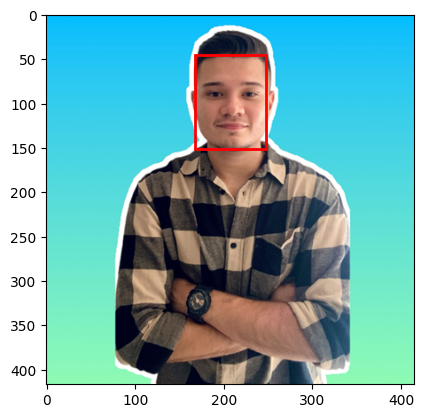

In [3]:
# Load and image
img = PIL.Image.open("../assets/me.png").convert(mode="RGB")

# Convert it to array
img = np.array(img)

# Create mtcc object
detector = MTCNN(min_face_size=30)

# Detect faces
resultados = detector.detect_faces(img)

# Plots
fig, ax = plt.subplots()
ax.imshow(img)
for resultado in resultados:
    x, y, w, h = resultado['box']
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


Let's use MTCNN tools from facenet_pytorch and crop the face 

In [4]:
del MTCNN
from facenet_pytorch import MTCNN

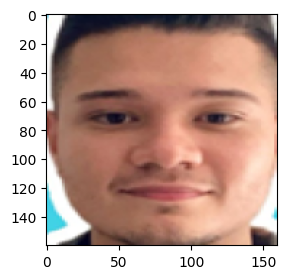

In [5]:
mtcnn = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=False)
cropped_img = mtcnn(img).permute(1, 2, 0).int().numpy()
plt.figure(figsize=(3,3))
plt.imshow(cropped_img)
plt.show()

Let's compute a Embedding

In [6]:
mtcnn_detector = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=True)
resnet = InceptionResnetV1(pretrained="vggface2", classify=False, device = device).eval()
cropped_img = mtcnn_detector(img).unsqueeze(0)
embedding = resnet(cropped_img)
print(f"Our embedding has a dimension of {embedding.shape[1]}")

Our embedding has a dimension of 512


Let's create our FaceDataset

In [12]:
ds = FaceDataset(root_dir="../data/unstructured/imgs")
dataloader = DataLoader(ds, batch_size=4, shuffle=True)

Plot some images

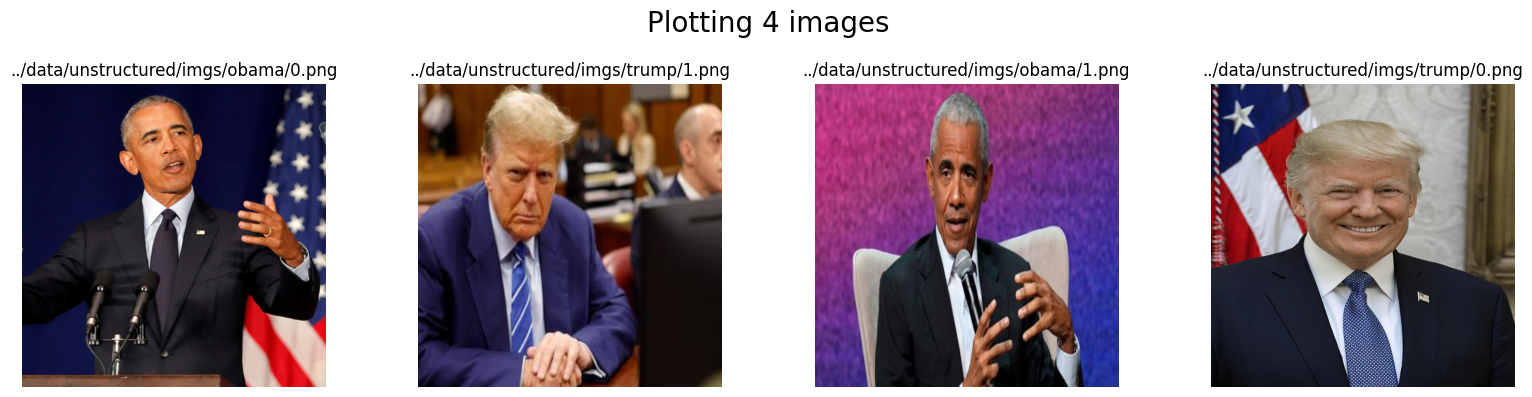

In [8]:
test_imgs, labels_imgs = next(iter(dataloader))
test_imgs = [np.array(img) for img in test_imgs]
plot_images_horizontal(test_imgs, labels_imgs)

Process the dataset by batch detecting faces and computing embeddings 

In [13]:
embeddings = []
used = []
with torch.no_grad():
    for run, (batch, idxs) in enumerate(dataloader):
        print (f"Batch # {run+1} of size {dataloader.batch_size}")
        to_use = []
        batch_images = []
        not_used = []
        for idx, img in enumerate (batch):
            detected_face, prob = mtcnn_detector(img, return_prob=True)
            if prob is not None:
                batch_images.append(detected_face.to(device))
                used.append(idxs[idx])
            else:
                not_used.append(idxs[idx])

        if len (batch_images) > 0:
            embedding = resnet(torch.stack(batch_images)).to("cpu")
            used.extend(to_use)
            embeddings.append(embedding)

            del batch_images, to_use, detected_face, embedding
            torch.cuda.empty_cache()

Batch # 1 of size 4s
Batch # 2 of size 4s


Persists embeddings and labels

In [20]:
data = [torch.cat(embeddings, dim=0), used]
torch.save(data, "../data/unstructured/imgs_embeddings/data.pt")

Create client

In [9]:
client = QdrantClient(host="localhost", port=6333)

Recreate collection

In [43]:
my_collection = "face_embeddings2"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE)
)

True

Upsert records

In [66]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=[i for i in range(len(used))],
        vectors=torch.cat(embeddings, dim=0).tolist(),
        payloads = [{"path": path[1:]} for path in used]
    )
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

Test with an image

In [49]:
import PIL.Image

test = PIL.Image.open("../assets/obama_test.png")
test = test.convert(mode="RGB")

Compute embeddings

In [67]:
detected_face, prob = mtcnn_detector(test, return_prob=True)
embedding = resnet(detected_face.unsqueeze(0))

Search into collection

In [68]:
client.search(
    collection_name=my_collection,
    query_vector=embedding.detach().cpu().numpy().tolist()[0],
    score_threshold=0.6,
    limit=10
)

[ScoredPoint(id=4, version=1, score=0.69455683, payload={'path': './data/unstructured/imgs/obama/2.png'}, vector=None, shard_key=None),
 ScoredPoint(id=3, version=1, score=0.6854315, payload={'path': './data/unstructured/imgs/obama/0.png'}, vector=None, shard_key=None),
 ScoredPoint(id=1, version=1, score=0.632252, payload={'path': './data/unstructured/imgs/obama/1.png'}, vector=None, shard_key=None)]

## Product's Images Similarity Search

Load model for Feature Extraction and Image Processor

In [2]:
from transformers import ViTImageProcessor, ViTModel

model_id = 'jolual2747/vit-clothes-classification'
processor = ViTImageProcessor.from_pretrained(model_id)
model = ViTModel.from_pretrained(model_id)

Some weights of ViTModel were not initialized from the model checkpoint at jolual2747/vit-clothes-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load Dataset and download images from URLs

In [3]:
from datasets import load_dataset
from utils.computer_vision import fetch_images

num_threads = 20
dset = load_dataset('DBQ/Matches.Fashion.Product.prices.France')
dset = dset.shuffle(42)["train"].select(range(3000))
dset = dset.map(fetch_images, batched=True, batch_size=20, fn_kwargs={"num_threads": num_threads})

Preprocess images

In [4]:
def preprocess_image(batch: dict):
    images = [image for image in batch["image"]]
    inputs = processor(images=images, return_tensors="pt")
    return inputs

dset = dset.map(preprocess_image, batched=True, batch_size=8)   

Compute embeddings

In [5]:
def create_embeddings(batch: dict):
    pixel_values = torch.stack([torch.tensor(b) for b in batch["pixel_values"]])
    inputs = {"pixel_values": pixel_values}
    outputs = model(**inputs)
    last_hidden_states = outputs.pooler_output
    return {"pooler_output": last_hidden_states}

dset = dset.map(create_embeddings, batched=True, batch_size=10)

Map:  21%|██▏       | 640/3000 [04:22<15:56,  2.47 examples/s]

Get Pandas DataFrame and generate payload for Qdrant

In [ ]:
ds_pandas = dset.to_pandas()
ds_pandas["id"] = np.array([i for i in range(ds_pandas.shape[0])])
payload = ds_pandas[["id", "category2_code", "title", "category3_code"]].to_dict(orient="records")

In [11]:
ds_pandas[["id", "category2_code", "title", "category3_code"]].to_csv("products.csv", index = None)

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,...,imageurl,full_price,price,full_price_eur,price_eur,flg_discount,image,pixel_values,pooler_output,id
0,Matches Fashion,2023-11-17,FRA,EUR,BEGÜM KHAN,WOMENS,ACCESSORIES,FASHION JEWELRY,1548400,Lotus 24kt gold-plated clip earrings,...,https://assetsprx.matchesfashion.com/img/15484...,1504.0,1504.0,1504.0,1504.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.8666667, 0.8745098, 0.88235295, 0.8823529...","[-0.055278614, -0.07257557, -0.015907137, -0.2...",0
1,Matches Fashion,2023-11-17,FRA,EUR,IRENE NEUWIRTH,WOMENS,ACCESSORIES,FINE JEWELRY,1551010,Gemmy Gem tourmaline & 18kt rose-gold necklace,...,https://assetsprx.matchesfashion.com/img/15510...,10275.0,10275.0,10275.0,10275.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.8666667, 0.8666667, 0.8666667, 0.8666667,...","[-0.12988584, -0.22204545, -0.1395263, -0.1671...",1
2,Matches Fashion,2023-11-17,FRA,EUR,ALIGHIERI,WOMENS,ACCESSORIES,FASHION JEWELRY,1551867,The Rocky Road 24kt gold-plated bracelet,...,https://assetsprx.matchesfashion.com/img/15518...,513.0,513.0,513.0,513.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.8509804, 0.8509804, 0.8509804, 0.84313726...","[0.12210795, 0.05543526, 0.026198378, -0.26700...",2
3,Matches Fashion,2023-11-17,FRA,EUR,HERNO,MENS,CLOTHING,COATS,1533662,Hooded nylon-blend parka,...,https://assetsprx.matchesfashion.com/img/15336...,641.0,641.0,641.0,641.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.9372549, 0.9372549, 0.9372549, 0.9372549,...","[0.3256955, -0.025203746, -0.12409839, 0.35284...",3
4,Matches Fashion,2023-11-17,FRA,EUR,LES OTTOMANS,WOMENS,HOMEWARE,TABLETOP,1503435,Set of four hand-painted ceramic dinner plates,...,https://assetsprx.matchesfashion.com/img/15034...,269.0,269.0,269.0,269.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.90588236, 0.90588236, 0.90588236, 0.90588...","[0.29250115, -0.057077833, -0.12047629, 0.0788...",4


Create client

In [10]:
client = QdrantClient(host="localhost", port=6333)

Create collection

In [11]:
my_collection = "products"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=768, distance=models.Distance.COSINE)
)

True

In [12]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=ds_pandas["id"],
        vectors=ds_pandas["pooler_output"],
        payloads = payload
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

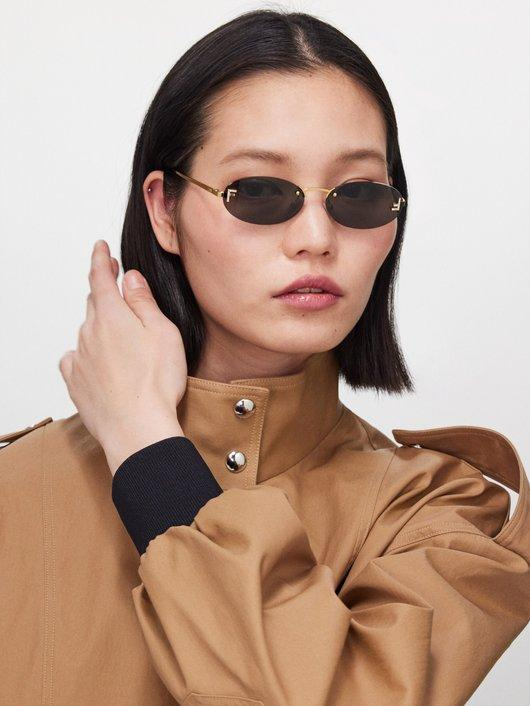

In [13]:
image = dset[10]["image"]

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
embedding = outputs.pooler_output
image

In [14]:
results = client.search(
    collection_name=my_collection,
    query_vector=embedding.detach().cpu().numpy().tolist()[0],
    score_threshold = 0.4,
    limit=10
)

In [15]:
res = [result.id for result in results]
res

[10, 621, 485, 622, 16, 739, 602, 70, 644, 266]

In [16]:
results

[ScoredPoint(id=10, version=0, score=0.99999976, payload={'category3_code': 'SUNGLASSES', 'id': 10}, vector=None, shard_key=None),
 ScoredPoint(id=621, version=0, score=0.95986605, payload={'category3_code': 'SUNGLASSES', 'id': 621}, vector=None, shard_key=None),
 ScoredPoint(id=485, version=0, score=0.95877725, payload={'category3_code': 'SUNGLASSES', 'id': 485}, vector=None, shard_key=None),
 ScoredPoint(id=622, version=0, score=0.9524914, payload={'category3_code': 'SUNGLASSES', 'id': 622}, vector=None, shard_key=None),
 ScoredPoint(id=16, version=0, score=0.95195895, payload={'category3_code': 'SUNGLASSES', 'id': 16}, vector=None, shard_key=None),
 ScoredPoint(id=739, version=0, score=0.9507189, payload={'category3_code': 'SUNGLASSES', 'id': 739}, vector=None, shard_key=None),
 ScoredPoint(id=602, version=0, score=0.93594694, payload={'category3_code': 'SUNGLASSES', 'id': 602}, vector=None, shard_key=None),
 ScoredPoint(id=70, version=0, score=0.93487394, payload={'category3_code':

In [17]:
from io import BytesIO
images = []
for row in ds_pandas.iloc[res,]["image"]:
    images.append(np.array(PIL.Image.open(BytesIO(row["bytes"]))))

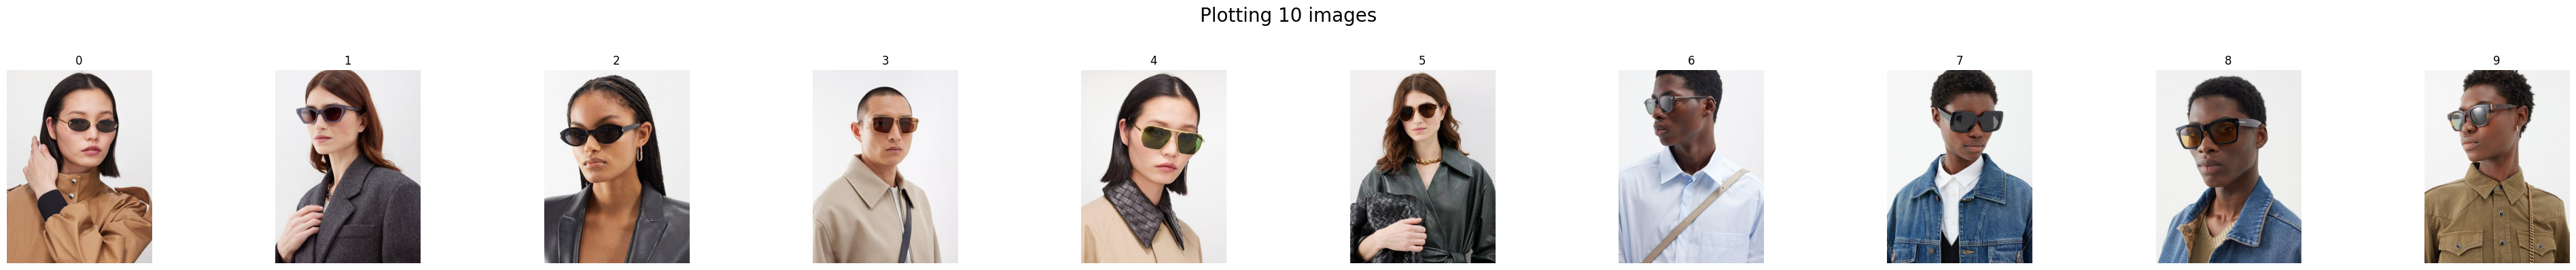

In [18]:
plot_images_horizontal(images, titles=[str(i) for i in range(len(images))])

In [4]:
ds_pandas

NameError: name 'ds_pandas' is not defined